# Exploratory Data Analysis

In [23]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pathlib
import time 

from src.data.dataset_loader import load_distracted_driver_detection_list, load_dataset_image_label
from src.data.image_label_loader import ImageLabelLoader
from src.visualization.image_visualization import visualize_train_images
from src.utils.data_util import sample_dataset, get_paths

# Auto reload external modules in ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Split Training Set and Validation Set

In [24]:
data_dir = pathlib.Path("dataset/raw/imgs/train") # Train directory

X_train_filenames, X_val_filenames, y_train_labels, y_val_labels = load_distracted_driver_detection_list(val_size=0.2, split_on_driver=True, random_state=12)
train_paths = get_paths(data_dir, X_train_filenames, y_train_labels)
val_paths = get_paths(data_dir, X_val_filenames, y_val_labels)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

num_train = len(train_paths)
num_val = len(val_paths)
num_classes = len(class_names)

print(f'Training set size: {num_train}')
print(f'Validation set size: {num_val}')
print(f'Number of classes: {num_classes}')

Training set size: 17761
Validation set size: 4663
Number of classes: 10
img_44733.jpg
dataset\raw\imgs\train\c0\img_44733.jpg


# Class Distribution

Train Set

<BarContainer object of 10 artists>

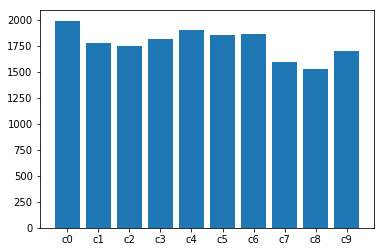

In [3]:
# Distribution of labels in training set
train_labels, train_counts = np.unique(y_train_labels, return_counts=True)
plt.bar(train_labels, train_counts)

Validation Set

<BarContainer object of 10 artists>

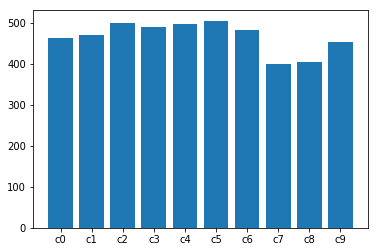

In [4]:
# Distribution of labels in validation set
val_labels, val_counts = np.unique(y_val_labels, return_counts=True)
plt.bar(val_labels, val_counts)

In [25]:
# Sample dataset
train_paths = sample_dataset(train_paths, num_sample=100)
val_paths = sample_dataset(val_paths, num_sample=10)

# Naive Dataset Load

In [6]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_val, y_val
   print('Clear previously loaded data.')
except:
   pass

# Naive image load

tic = time.time()

X_train, y_train = load_dataset_image_label(train_paths, img_size=64)
X_val, y_val = load_dataset_image_label(val_paths, img_size=64)

toc = time.time()
load_time = toc-tic

print('Load time using naive implementation: ', load_time)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)



Load time using naive implementation:  0.6661319732666016
Training data shape:  (50, 64, 64, 3)
Training labels shape:  (50,)
Validation data shape:  (10, 64, 64, 3)
Validation labels shape:  (10,)


# Tensorflow tf.data.Dataset Load

In [26]:
rng = tf.random.Generator.from_seed(123, alg='philox')

def wrap_augment(image, label):
    seed = rng.make_seeds(2)[0]
    image = augment(image, seed)
    return image, label

def augment(image, seed):
    image = tf.image.stateless_random_brightness(image, max_delta=0.3, seed=seed)
    image = tf.image.stateless_random_hue(image, max_delta=0.5, seed=seed)
    image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1.2, seed=seed)
    image = tf.image.stateless_random_saturation(image, lower=1, upper=1.2, seed=seed)
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100, seed=seed)
    #image = tf.image.stateless_random_crop(image, size=(110,110,3), seed=seed)
    #image = tf.image.stateless_random_flip_left_right(image, seed)
    #image = tf.image.stateless_random_flip_up_down(image, seed)
    return image

In [40]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train, train_dset
   del X_val, y_val, val_dset
   print('Clear previously loaded data.')
except:
   pass

CPU = '/cpu:0'
GPU = '/device:GPU:0'

BATCH_SIZE = 100 # Load all to 1 batch
IMG_SHAPE = (224, 224, 3)
loader = ImageLabelLoader(class_names, img_shape=IMG_SHAPE)

tic = time.time()

# Force image load and preprocessing with specific device
with tf.device(CPU):
    # Train dataset input pipeline
    train_dset = tf.data.Dataset.from_tensor_slices(train_paths)
    #train_dset = train_dset.shuffle(buffer_size=num_train, reshuffle_each_iteration=True)
    train_dset = train_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Load from path to image, label
    #train_dset = train_dset.map(wrap_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Image augmentation
    train_dset = train_dset.batch(BATCH_SIZE, drop_remainder=False)
    train_dset = train_dset.cache()
    train_dset = train_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Validation dataset input pipeline
    val_dset = tf.data.Dataset.from_tensor_slices(val_paths)
    val_dset = val_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #val_dset = val_dset.map(wrap_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Image augmentation
    val_dset = val_dset.batch(BATCH_SIZE, drop_remainder=False)
    val_dset = val_dset.cache()
    val_dset = val_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

X_train, y_train = next(iter(train_dset))
X_val, y_val = next(iter(val_dset))

# Convert to numpy
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()

toc = time.time()
load_time = toc-tic

print('Load time using tensorflow implementation: ', load_time)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Clear previously loaded data.
Load time using tensorflow implementation:  0.42786407470703125
Training data shape:  (100, 224, 224, 3)
Training labels shape:  (100,)
Validation data shape:  (10, 224, 224, 3)
Validation labels shape:  (10,)


# Visualize Dataset

c0: Safe Driving
c1: Texting - Right
c2: Talking on the phone - Right
c3: Texting - Left
c4: Talking on the phone - Left
c5: Operating The Radio
c6: Drinking
c7: Reaching Behind
c8: Hair and Makeup
c9: Talking to Passanger


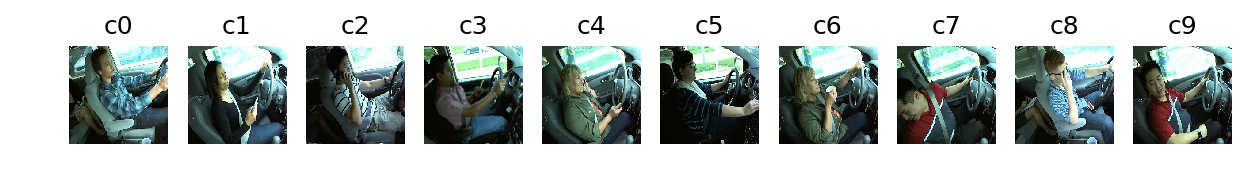

In [41]:
class_desc = ['Safe Driving', 'Texting - Right', 'Talking on the phone - Right', 
'Texting - Left', 'Talking on the phone - Left', 'Operating The Radio', 
'Drinking', 'Reaching Behind', 'Hair and Makeup', 'Talking to Passanger']
class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

for class_name, class_desc in zip(class_names, class_desc):
    print(f'{class_name}: {class_desc}')

visualize_train_images(class_names, X_train, y_train, samples_per_class=1)